- RAM : 16GB  
- Processor : i5 1240p

- Ensemble Balanceing Techniques: 
    - Balanced Random forest Classifier
    - Balanced Bagging Classifier
    - RUS Boost Classifier (Boosting) 
    - Easy Ensemble Classiifer (Balanced Ada Boost Classifier)

# Balanced Ensambles

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# Reading the file
df = pd.read_csv("all_three.csv")

# Dropping the first column because it is of no use  
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Segregating the features and labels 
Y = df[['label']]
X = df[['rec/sent','amount','size','weight','version','lock_time','is_coinbase',
        'has_witness','input_count','output_count','input_total_usd','output_total_usd',
        'fee_usd','fee_per_kb_usd','fee_per_kwu_usd','cdd_total']]

# Decimal point normalization (scaling each column by its max power of 10)
for col in X.columns: 
    max_val = X[col].max()
    q = len(str(abs(int(max_val)))) if max_val != 0 else 1
    X[col] = X[col] / (10**q)

# Splitting the data (60-40 split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y) 

# Oversampling using SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)


In [2]:
!pip install seaborn

In [3]:
# -----------------------------
# Required imports
# -----------------------------
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as mplplt  # renamed to avoid overwriting issues
import psutil, os
import pandas as pd
import numpy as np
from time import time

# -----------------------------
# Full check_prediction function
# -----------------------------
def check_prediction(y_true, y_pred, start_time, model=None, x_test=None, x_train=None): 
    runtime_sec = time() - start_time
    
    # RAM usage
    process = psutil.Process(os.getpid())
    ram_used_mb = process.memory_info().rss / (1024 * 1024)
    
    # Base metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    # ROC AUC
    roc_auc = None
    y_probs = None
    try:
        if model is not None and x_test is not None:
            if hasattr(model, "predict_proba"):
                y_probs = model.predict_proba(x_test)
            elif hasattr(model, "decision_function"):
                y_probs = model.decision_function(x_test)

        if y_probs is not None:
            classes = np.unique(y_true)
            y_true_bin = label_binarize(y_true, classes=classes)
            roc_auc = roc_auc_score(y_true_bin, y_probs, average="weighted", multi_class="ovr")
    except Exception as e:
        print(f"⚠ ROC AUC not available: {e}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print("\n===== Evaluation Results =====")
    print(f"runtime_sec: {runtime_sec:.4f}")
    print(f"ram_used_mb: {ram_used_mb:.4f}")
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"roc_auc: {roc_auc:.4f}" if roc_auc else "roc_auc: N/A")
    print("confusion_matrix:\n", cm)
    print("================================\n")

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # -----------------------------
    # Confusion Matrix Heatmap
    # -----------------------------
    fig_cm, ax_cm = mplplt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax_cm)
    ax_cm.set_title("Confusion Matrix")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    mplplt.show()

    # -----------------------------
    # ROC Curve plotting
    # -----------------------------
    if y_probs is not None:
        try:
            if y_probs.ndim > 1 and y_probs.shape[1] > 1:  # multiclass
                n_classes = y_probs.shape[1]
                classes = np.unique(y_true)
                y_true_bin = label_binarize(y_true, classes=classes)

                fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
                    roc_auc_val = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={roc_auc_val:.2f})")

                ax_roc.plot([0,1],[0,1],'k--')
                ax_roc.set_title("ROC Curves (Multiclass)")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                mplplt.show()
            else:  # binary
                if len(np.unique(y_true)) == 2:
                    fpr, tpr, _ = roc_curve(y_true, y_probs)
                    roc_auc_val = auc(fpr, tpr)
                    fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc_val:.2f}")
                    ax_roc.plot([0,1],[0,1],'k--')
                    ax_roc.set_title("ROC Curve (Binary)")
                    ax_roc.set_xlabel("False Positive Rate")
                    ax_roc.set_ylabel("True Positive Rate")
                    ax_roc.legend(loc="lower right")
                    mplplt.show()
        except Exception as e:
            print(f"⚠ ROC plotting failed: {e}")

    # -----------------------------
    # Feature Correlation Heatmap
    # -----------------------------
    if x_train is not None:
        corr = pd.DataFrame(x_train).corr()
        fig_corr, ax_corr = mplplt.subplots(figsize=(10, 8))
        sns.heatmap(corr, cmap="coolwarm", annot=False, ax=ax_corr)
        ax_corr.set_title("Feature Correlation Heatmap")
        mplplt.show()


In [4]:
df['label'].value_counts()
print("training data size")
print(y_train.value_counts())
print("testing data size")
print(y_test.value_counts())

training data size
label
0        235092
1        235092
2        235092
3        235092
Name: count, dtype: int64
testing data size
label
0        100755
2         16617
3         10240
1           676
Name: count, dtype: int64


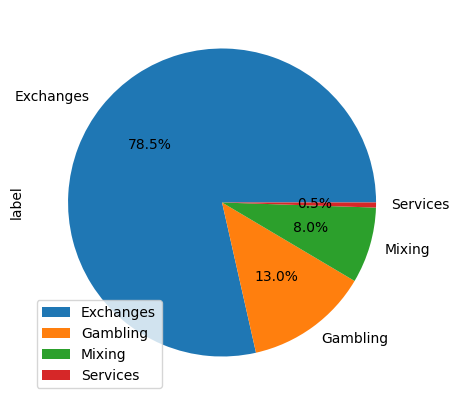

In [5]:
pf2=pd.DataFrame({'label':df['label'].value_counts().to_list()},
                    index=['Exchanges','Gambling', 'Mixing','Services'])

plt=pf2.plot.pie(y='label',autopct='%1.1f%%',figsize=(5,5))

## Balanced Random Forest Classifier


===== Evaluation Results =====
runtime_sec: 62.8217
ram_used_mb: 2575.1797
accuracy: 0.9620
precision: 0.9634
recall: 0.9620
roc_auc: 0.9918
confusion_matrix:
 [[97911   203     9  2632]
 [  200   471     0     5]
 [    9     0 16608     0]
 [ 1808    14     0  8418]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    100755
           1       0.68      0.70      0.69       676
           2       1.00      1.00      1.00     16617
           3       0.76      0.82      0.79     10240

    accuracy                           0.96    128288
   macro avg       0.86      0.87      0.86    128288
weighted avg       0.96      0.96      0.96    128288



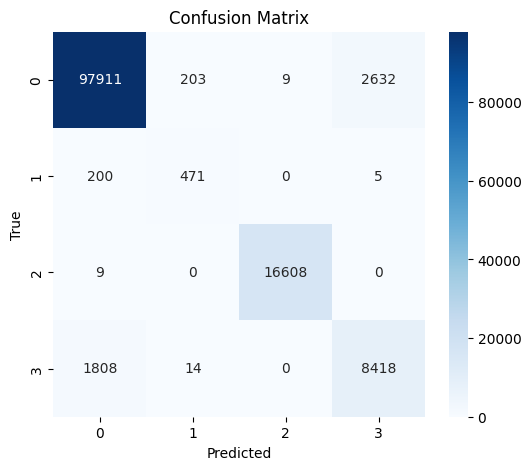

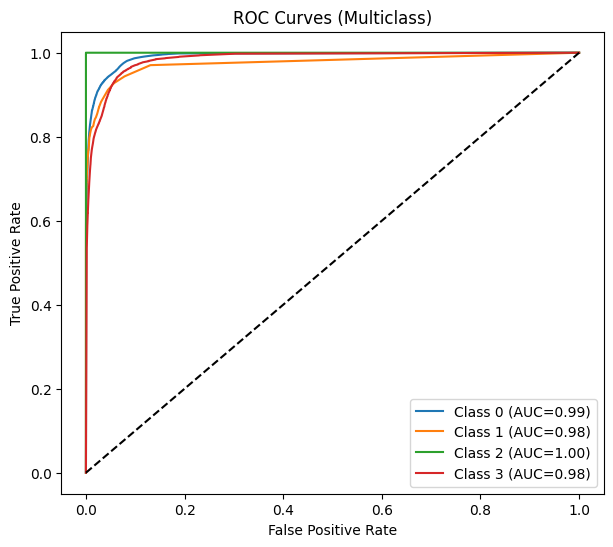

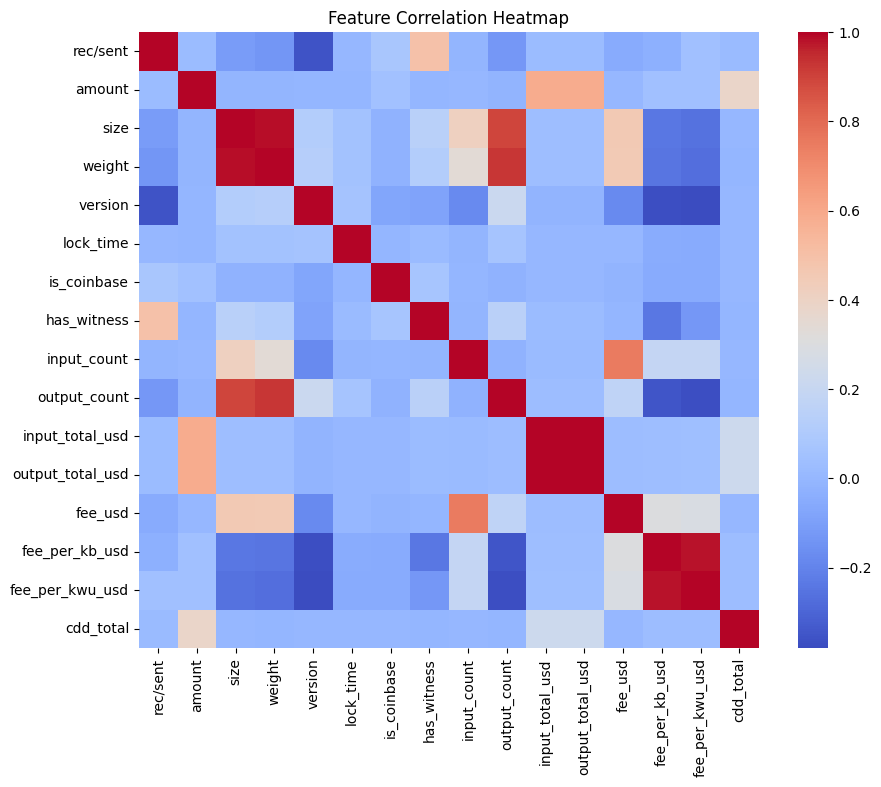

In [6]:
# --- Model training ---
start_time = time()
from imblearn.ensemble import BalancedRandomForestClassifier 
model = BalancedRandomForestClassifier(n_jobs=-1) 
model.fit(x_train, y_train) 

# predicting the model in testing dataset
y_pred = model.predict(x_test)

# Evaluating the model 
check_prediction(y_test, y_pred, start_time, model, x_test, x_train)

## Balanced Bagging Classifier

Cross-validation scores: [0.89513968 0.89603064 0.89812054]
Mean CV score: 0.8964302874954768

===== Evaluation Results =====
runtime_sec: 684.6437
ram_used_mb: 980.8047
accuracy: 0.9600
precision: 0.9623
recall: 0.9600
roc_auc: 0.9894
confusion_matrix:
 [[97627   373    12  2743]
 [  176   492     0     8]
 [   10     0 16606     1]
 [ 1793    20     0  8427]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    100755
           1       0.56      0.73      0.63       676
           2       1.00      1.00      1.00     16617
           3       0.75      0.82      0.79     10240

    accuracy                           0.96    128288
   macro avg       0.82      0.88      0.85    128288
weighted avg       0.96      0.96      0.96    128288



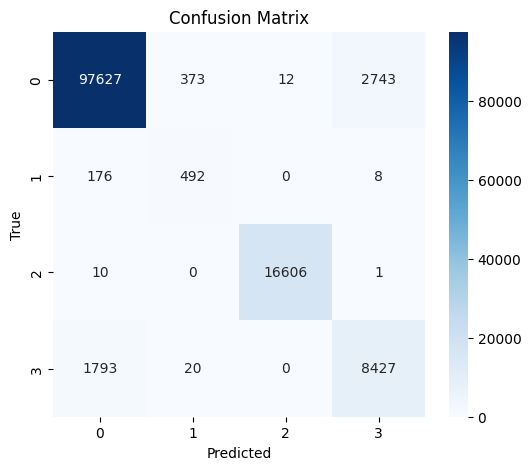

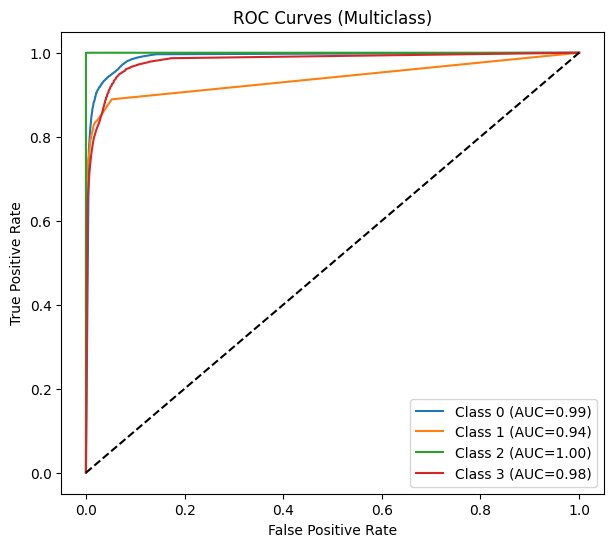

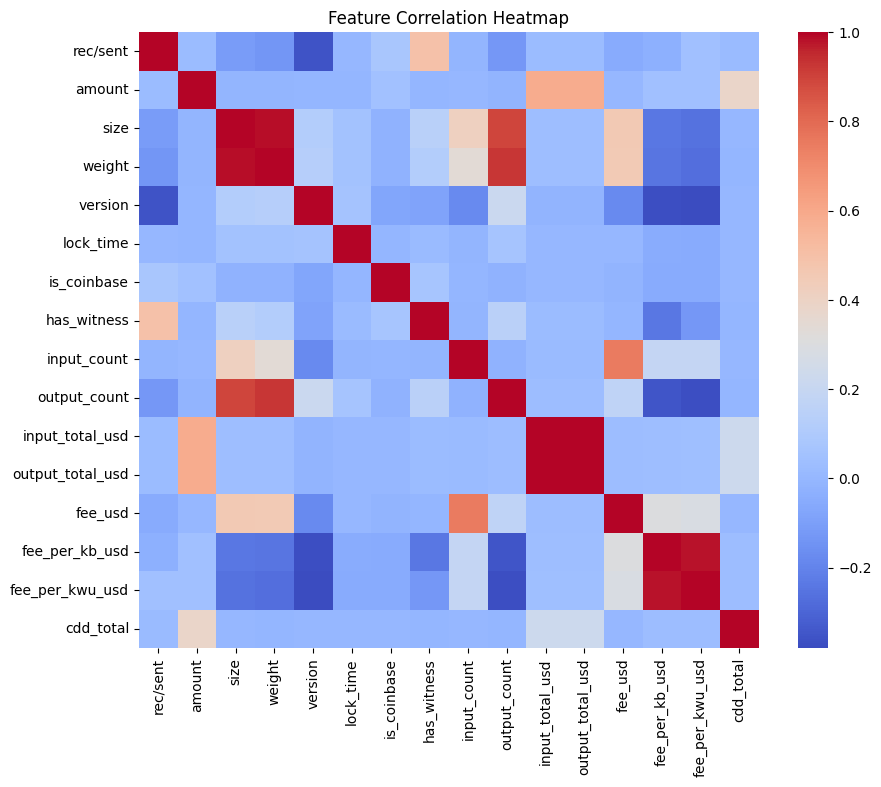

In [7]:
start_time = time()

# Bagging Classifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

# Base classifier
base_model = DecisionTreeClassifier()

# Number of base classifiers
n_trees = 50

# Initializing the bagging classifier 
model = BalancedBaggingClassifier(estimator=base_model, random_state=50, n_estimators=n_trees)

# Cross validation score
kfold = KFold(n_splits=3, random_state=None, shuffle=True)
res = cross_val_score(model, X, Y.values.ravel(), cv=kfold)
print("Cross-validation scores:", res)
print("Mean CV score:", res.mean())

# Fit on training set
model.fit(x_train, y_train.values.ravel())

# Predict on test set
y_pred = model.predict(x_test)

# Evaluate with extended evaluation function
check_prediction(y_test, y_pred, start_time, model, x_test, x_train)


## RUS Boost Classifier (Boosting)


===== Evaluation Results =====
runtime_sec: 9.5067
ram_used_mb: 538.7500
accuracy: 0.7364
precision: 0.9265
recall: 0.7364
roc_auc: 0.9382
confusion_matrix:
 [[68647 14377   994 16737]
 [  128   423    12   113]
 [  126   260 16231     0]
 [  466   460   142  9172]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.68      0.81    100755
           1       0.03      0.63      0.05       676
           2       0.93      0.98      0.95     16617
           3       0.35      0.90      0.51     10240

    accuracy                           0.74    128288
   macro avg       0.58      0.79      0.58    128288
weighted avg       0.93      0.74      0.80    128288



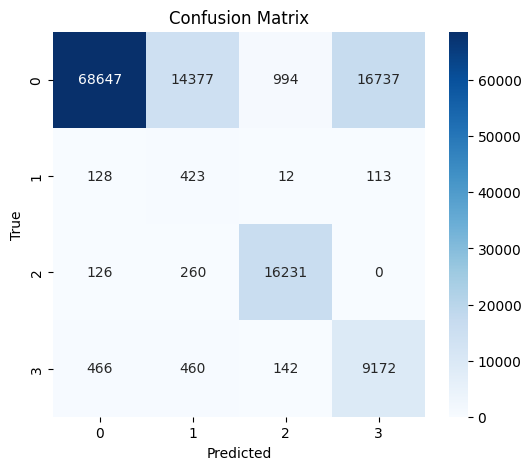

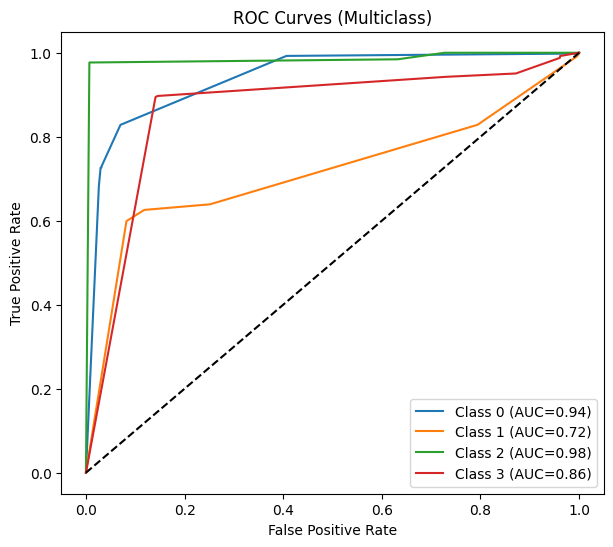

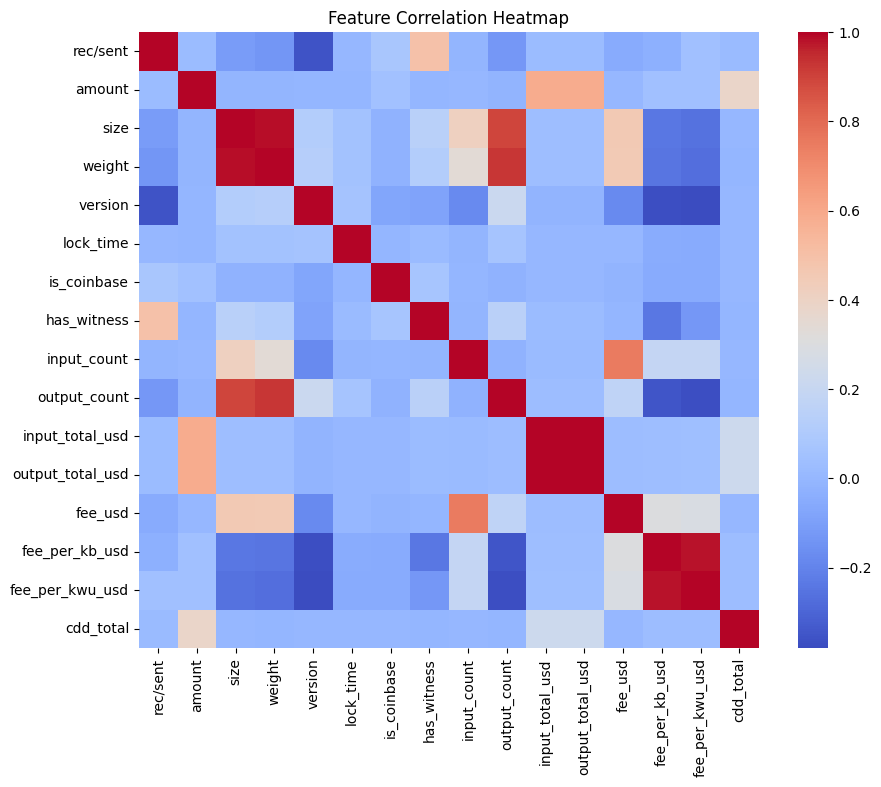

In [8]:
from time import time
from imblearn.ensemble import RUSBoostClassifier

# Start timer
start_time = time()

# Initialize and train RUSBoostClassifier
model = RUSBoostClassifier(n_estimators=4, random_state=42)
model.fit(x_train, y_train.values.ravel())

# Check predictions with metrics, runtime, RAM, and plots
check_prediction(
    y_true=y_test, 
    y_pred=model.predict(x_test), 
    start_time=start_time, 
    model=model,        # pass model for ROC AUC
    x_test=x_test,      # pass test features for probabilities
    x_train=x_train     # pass train features for correlation heatmap
)


## Easy Ensemble Classiifer (Balanced Ada Boost Classifier)


===== Evaluation Results =====
runtime_sec: 375.4407
ram_used_mb: 547.9688
accuracy: 0.8020
precision: 0.9301
recall: 0.8020
roc_auc: 0.9449
confusion_matrix:
 [[77468 10759   556 11972]
 [  115   537     7    17]
 [  141    66 16407     3]
 [ 1099   616    46  8479]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    100755
           1       0.04      0.79      0.08       676
           2       0.96      0.99      0.98     16617
           3       0.41      0.83      0.55     10240

    accuracy                           0.80    128288
   macro avg       0.60      0.84      0.62    128288
weighted avg       0.93      0.80      0.85    128288



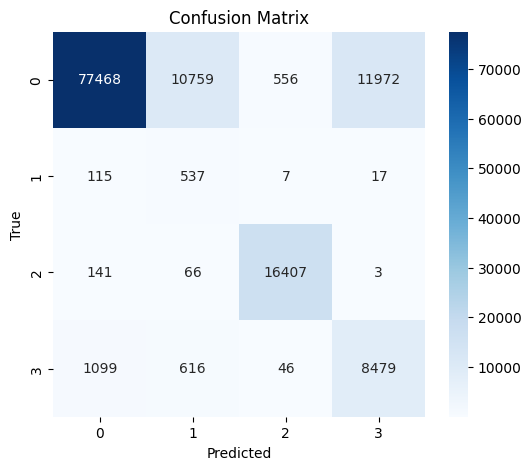

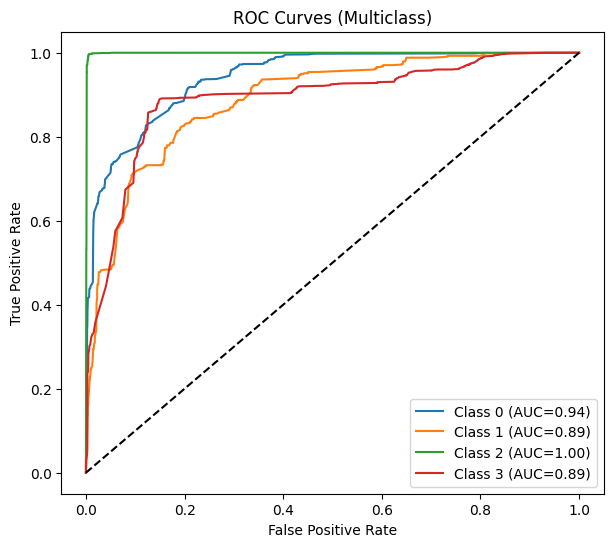

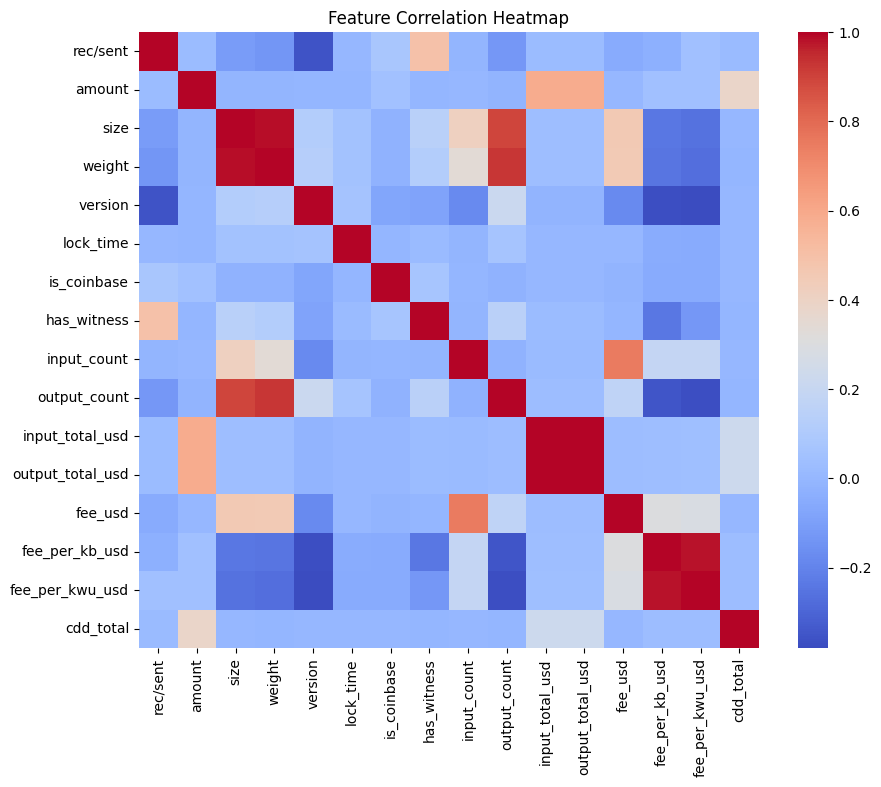

In [9]:
from time import time
from imblearn.ensemble import EasyEnsembleClassifier

# Start timer
start_time = time()

# Initialize and train EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=4, random_state=42)
model.fit(x_train, y_train.values.ravel())

# Evaluate using the custom check_prediction function
check_prediction(
    y_true=y_test,
    y_pred=model.predict(x_test),
    start_time=start_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for correlation heatmap
)
